In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import gamma

def create_df(a,n,x_settings,data_values):
    id_list = [[0 for i in range(n)] for j in range(a)]
    for i in range(a):
        id_list[i] = x_settings[i]*np.ones(n)
    id = np.concatenate([id_list[i] for i in range(a)])
    data2 = np.transpose(np.vstack((data_values,id)))
    df = pd.DataFrame(data2,columns=['value','treatment'])
    
    return df

def create_ybar(a,n,data_values):
    ybar = [0 for i in range(a)]
    for i in range(a):
        ybar[i] = data_values[i*n:i*n+n].mean()
    print("ybar vector = ",ybar)
    return ybar

def brash_plot(a,n,x_settings,ybar,sembar,df):
    plt.errorbar(x_settings,ybar,yerr=sembar,fmt='o')
    plt.plot(df['treatment'],df['value'],'.')

    ybarbar = df['value'].mean()
    print("ybarbar = ",ybarbar)
    ynoeffect = [ybarbar for i in range(a)]
    plt.plot(x_settings,ynoeffect,'-')
    plt.show()
    return

def brash_plot_summary(a,n,x_settings,ybar,sembar):
    plt.errorbar(x_settings,ybar,yerr=sembar,fmt='o')

    ybarbar = ybar.mean()
    print("ybarbar = ",ybarbar)
    ynoeffect = [ybarbar for i in range(a)]
    plt.plot(x_settings,ynoeffect,'-')
    plt.show()
    return

def q_tukey(k, v, alpha):

    qarray = []
    for k in range(2,k+1):
        print ("q_tukey: calculating k = ",k)

        dq = 0.001
        qd = np.array(np.arange(0.000,6.000,dq))

        f = []
        fs = []
        found = False

        for i in range(len(qd)):
            q = qd[i]
            prefactor = np.sqrt(2.0*np.pi)*k*(k-1)*v**(v/2.0)/(gamma(v/2.0)*2**(v/2.0-1))
            npts = 100

            xh = 6.0
            xl = 0.0
            dx = (xh-xl)/npts

            x = np.arange(xl,xh,dx)
            x = x.reshape(1,-1)
    
            ul = -6.0
            uh = 6.0
            du = (uh-ul)/npts
            
            u = np.arange(ul,uh,du)
            u = u.reshape(-1,1)
            
            phi_u = stats.norm.pdf(u)
            phi_ux = stats.norm.pdf(u-q*x)
            Phi_u = stats.norm.cdf(u)
            Phi_ux = stats.norm.cdf(u-q*x)
            phi_x = stats.norm.pdf(np.sqrt(v)*x)
            
            integrand = x**v*phi_x*phi_u*phi_ux*(Phi_u-Phi_ux)**(k-2)*du*dx
            
            #print ("U integral matrix")
            #print(u,phi_u,phi_ux,Phi_u,Phi_ux,phi_x,x**v,integrand)
        
            sumux = integrand.sum()
            
            #print ("U sum")
            #print(sumux)
            
            #print ("X sum * prefactor")
            #print (sumux*prefactor)

            f.append(sumux*prefactor)
            
            if (i>0):
                fs.append(f[i]*dq+fs[i-1])
            else:
                fs.append(f[i]*dq)

            if (fs[i]>(1-alpha) and not(found)):
                q_critical = qd[i-1] + ((1-alpha)-fs[i-1])*(qd[i]-qd[i-1])/(fs[i]-fs[i-1])
                print ("q_critical = ",q_critical)
                found = True
        
            #print(q,f[i],fs[i])
            
        qarray.append(q_critical)
        plt.scatter(q_critical,(1-alpha))
    
        f = np.array(f)
        fs = np.array(fs)
        plt.plot(qd,fs)

    qarray=np.array(qarray)
    return qarray

def fpvalue(fvalue,dof1,dof2,test):
    fdist = stats.f(dof1,dof2)

    if (fvalue > 1):
        if test == "upper":
            pvalue = (1-fdist.cdf(fvalue))
        if test == "two":
            pvalue = 2.0*(1-fdist.cdf(fvalue))
        if test == "lower":
            pvalue = fdist.cdf(fvalue)
    else:
        if test == "upper":
            pvalue = fdist.cdf(fvalue)
        if test == "two":
            pvalue = 2.0*fdist.cdf(fvalue)
        if test == "lower":
            pvalue = (1-fdist.cdf(fvalue))
            
    print ("Pvalue = %0.3f" % (pvalue))

# Question 1

As the population ages, there is increasing concern about accident-related injuries to the elderly. An article reported on an experiment in which the maximum lean angle—the furthest a subject is able to lean and still recover in one step—was determined for both a sample of younger females (21-29 years) and a sample of older females (67-81 years). The following observations are consistent with summary data given in the article.

YF:	32,	29,	31,	26,	29,	36,	29,	27,	35,	26

OF:	17,	13,	21,	22,	22

Carry out a test at significance level .10 to see whether the population standard deviations for the two age groups are different (normal probability plots support the necessary normality assumption). (Give answer accurate to 2 decimal places.)



In [5]:
yf = np.array([31, 30, 26, 28, 35, 35, 26, 33, 31, 34])
of = np.array([16, 17, 20, 17, 18])

In [6]:
n1 = len(yf)
n2 = len(of)

dof1 = n1-1
dof2 = n2-1

s1 = yf.std(ddof=1)
s2 = of.std(ddof=1)

xbar1 = yf.mean()
xbar2 = of.mean()

fvalue = s1**2/s2**2

print ("Standard Deviations of the two samples = %.1f, %.1f" %(s1,s2))
print ("Variances of the two samples = %.1f, %.1f" %(s1**2,s2**2))
print ("F statistic = %0.3f" % fvalue)

alpha = 0.10

fdist = stats.f(dof1,dof2)
flow = fdist.ppf(alpha/2)
fhigh = fdist.ppf(1-alpha/2)

print ("Critical F-values = %0.3f, %0.3f" % (flow,fhigh))
print ("Fail to Reject")

if (fvalue > 1):
    pvalue = 2.0*(1-fdist.cdf(fvalue))
else:
    pvalue = 2.0*fdist.cdf(fvalue)
    
print ("Pvalue = %0.3f" % (pvalue))

pvalue = fpvalue(fvalue,dof1,dof2,"two")

Standard Deviations of the two samples = 3.4, 1.5
Variances of the two samples = 11.7, 2.3
F statistic = 5.068
Critical F-values = 0.275, 5.999
Fail to Reject
Pvalue = 0.133
Pvalue = 0.133


# Question 2

In a study to assess the effects of malaria infection on mosquito hosts, mosquitos were fed on either infective or noninfective rhesus monkeys. Subsequently the distance they flew during a 24-hour period was measured using a flight mill. The mosquitos were divided into four groups of eight mosquitos each: infective rhesus and sporozites present (IRS), infective rhesus and oocysts present (IRD), infective rhesus and no infection developed (IRN), and noninfective (C). The summary data values are x1. = 4.28 (IRS), x2. = 4.81 (IRD), x3. = 5.39 (IRN), x4. = 5.88 (C), x.. = 5.09, ΣΣxij 2 = 955.6192. Use the ANOVA F test at level .05 to decide whether there are any differences between true average flight times for the four treatments. (Give answers accurate to 2 decimal places.)

This question involves the use of summary statistics, which is very typically when looking at published papers. Rather than giving all of the raw data, they give the averages of each group, the number of groups and the number of samples within each group, and one extra quantity - $\sum_i \sum_j {x_{ij}^2}$.

With these quantities, we can find all of the necessary quantities for carrying out 
a typical one-way ANOVA!

$SS_{total} = \sum_{i=1}^{a} \sum_{j=1}^{n} {(x_{ij}-\bar{\bar{x}})^2}$


$SS_{total} = \sum_{i=1}^{a} \sum_{j=1}^{n} {(x_{ij}^2-2x_{ij}\bar{\bar{x}} + \bar{\bar{x}}^2)}$

$SS_{total} = \sum_{i=1}^{a} \sum_{j=1}^{n} {x_{ij}^2} -2\bar{\bar{x}}\sum_{i=1}^{a} \sum_{j=1}^{n} {x_{ij}} + \bar{\bar{x}}^2 \sum_{i=1}^{a} \sum_{j=1}^{n} {1}$

From here, we know that:

$\sum_{i=1}^{a} \sum_{j=1}^{n} {1} = N$

and

$\sum_{j=1}^{n} {x_{ij}} = N \bar{\bar{x}}$

and therefore:

$SS_{total} = \sum_{i=1}^{a} \sum_{j=1}^{n} {x_{ij}^2} - N \bar{\bar{x}}^2$

We also know that:

$SS_{treatment} = \sum_{i=1}^{a} n(\bar{x}_i - \bar{\bar{x}})^2$

and

$SS_{error} = SS_{total} - SS_{treatment}$

In [8]:
a = 4
n = 8

# calculate DOF's
N = a*n
dof_total = N - 1
dof_treatment = a - 1
dof_error = dof_total - dof_treatment

# summary data for xbar
xbar = np.array([4.39,4.52,5.49,6.36])
xbarbar = xbar.mean()
#xbarbar = 5.19

# calculate SS_treatment
SS_treatment = 0.0
for x in xbar:
    SS_treatment += n*(x-xbarbar)**2
    
# calculate SS_total and SS_error
sumxij2 = 911.91
SS_total = sumxij2-N*xbarbar**2
SS_error = SS_total-SS_treatment

# Proceed with normal ANOVA from here
MS_treatment = SS_treatment/dof_treatment
MS_error = SS_error/dof_error

fSN = MS_treatment/MS_error

print ("F Signal/Noise = %0.2f " % fSN)

alpha = 0.05

fdist = stats.f(dof_treatment,dof_error)
fhigh = fdist.ppf(1-alpha)

print ("Critical F-value = %0.2f" % (fhigh))

if (fSN > 1):
    pvalue = (1-fdist.cdf(fSN))
else:
    pvalue = fdist.cdf(fSN)
    
print ("Pvalue = %0.3f" % (pvalue))

print ("sqrt(MS_error) = ",np.sqrt(MS_error))

F Signal/Noise = 6.43 
Critical F-value = 2.95
Pvalue = 0.002
sqrt(MS_error) =  1.027695063166666


ybarbar =  5.19


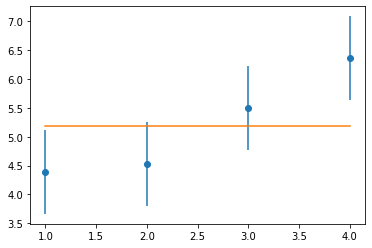

In [11]:
alpha = 0.05

sem = np.sqrt(MS_error/n)
x_settings = [1,2,3,4]
brash_plot_summary(a,n,x_settings,xbar,2.0*sem)

Standard Error = 0.363
Original Xbar =  [4.39 4.52 5.49 6.36]
Sorted Xbar =  [4.39 4.52 5.49 6.36]
q_tukey: calculating k =  2
q_critical =  2.892607535763244
q_tukey: calculating k =  3
q_critical =  3.498760365644071
q_tukey: calculating k =  4
q_critical =  3.8607437361038883
[2.89260754 3.49876037 3.86074374]
W = 1.4
[4.39, 4.52, 5.49, 6.36]
i j xbar1 xbar2 Diff Diff_comp Result
1 2 4.39 4.52 0.358  2.893 No Difference
1 3 4.39 5.49 3.027  3.499 No Difference
1 4 4.39 6.36 5.422  3.861 Yes - Difference
2 3 4.52 5.49 2.670  2.893 No Difference
2 4 4.52 6.36 5.064  3.499 Yes - Difference
3 4 5.49 6.36 2.394  2.893 No Difference


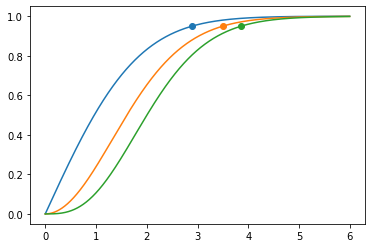

In [10]:
# Tukey's Procedure
#
# Step 1:  Calculate the standard error = sqrt(MS_error/n)

std_error = np.sqrt(MS_error/n)
print ("Standard Error = %0.3f" % std_error)

# Step 2:  Order the means from smallest to largest

print ("Original Xbar = ",xbar)
xbar_orig = xbar.copy()
xbar.sort()
print ("Sorted Xbar = ",xbar)

# Step 3:  Get the expected number of error bars (sem) between largest and smallest, for the number
# of means to be compared (a).  For this, we need the studentized range table values q(alpha,dof_error,k) for k=2..a.
# 
# http://www.real-statistics.com/statistics-tables/studentized-range-q-table/
# For this problem, dof_error = 15, alpha = 0.05, k = 2,3,4,5
# q = np.array([3.014,3.673,4.076,4.367])

#from q_tukey import q_tukey

n_means=len(xbar)
q = q_tukey(n_means,dof_error,alpha)
print (q)

# Step 4:  Calculate W = q(k=5)*std_error

W = q[n_means-2]*std_error

print ("W = %0.1f" % W)

# Step 5:  Make pair-wise comparisons

print (list(xbar_orig))

print ("i j xbar1 xbar2 Diff Diff_comp Result")
for i in range(len(xbar)):
    for j in range(len(xbar)):
        if (xbar[j] > xbar[i]):
            diff = (xbar[j] - xbar[i])/std_error
            diff_comp = q[j-i-1]
            if (diff>diff_comp):
                Result = "Yes - Difference"
            else:
                Result = "No Difference"
            iorig = list(xbar_orig).index(xbar[i])+1
            jorig = list(xbar_orig).index(xbar[j])+1
            print ("%0.0f %0.0f %0.2f %0.2f %0.3f  %0.3f %s" % (iorig,jorig,xbar[i],xbar[j],diff,diff_comp,Result))

# Question 3

The following data was reported on total Fe for four types of iron formation (1 = carbonate, 2 = silicate, 3 = magnetite, 4 = hematite).

1:	20.6	28.1	27.8	27.0	27.9	25.2	25.3	27.1	20.5	31.2

2:	26.2	24.0	26.2	20.2	23.5	34.0	17.1	26.8	23.7	24.7

3:	29.6	34.0	27.5	29.4	27.8	26.2	29.9	29.5	30.0	35.9

4:	36.9	44.2	34.1	30.3	31.5	33.1	34.1	32.9	36.3	25.6


Carry out an analysis of variance F test at significance level 0.01. State the appropriate hypotheses.

Summarize the results in an ANOVA table. (Round your answers two decimal places.)


                df     sum_sq     mean_sq          F    PR(>F)
C(treatment)   3.0  520.67875  173.559583  11.066479  0.000027
Residual      36.0  564.60100   15.683361        NaN       NaN
ybar vector =  [26.07, 24.639999999999997, 29.979999999999997, 33.900000000000006]
ybarbar =  28.647499999999997


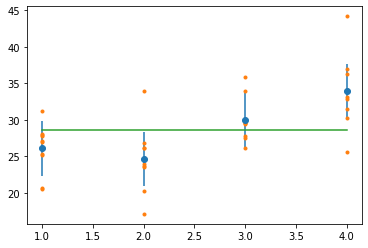

In [14]:
a = 4
n = 10

x_settings = [1,2,3,4]
data_values = np.array([20.6,28.1,27.8,27.0,27.9,25.2,25.3,27.1,20.5,31.2,
    26.2,24.0,26.2,20.2,23.5,34.0,17.1,26.8,23.7,24.7,
    29.6,34.0,27.5,29.4,27.8,26.2,29.9,29.5,30.0,35.9,
    36.9,44.2,34.1,30.3,31.5,33.1,34.1,32.9,36.3,25.6])

df = create_df(a,n,x_settings,data_values)

###################


from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('value ~ C(treatment)',df).fit()
anovaResults = anova_lm(model)

print (anovaResults)

#Let's plot things to see what it really looks like.

MS_error = anovaResults['mean_sq'][1]

sem = 3.0*np.sqrt(MS_error/n)

sembar = [sem for i in range(a)]

ybar = create_ybar(a,n,data_values)

brash_plot(a,n,x_settings,ybar,sembar,df)

# Question 4

A study was carried out to compare the writing lifetimes of four premium brands of pens (factor A). It was thought that the writing surface (factor B) might affect lifetime, so three different surfaces were randomly selected. A writing machine was used to ensure that conditions were otherwise homogeneous (e.g., constant pressure and a fixed angle). The accompanying table shows the two lifetimes (min) obtained for each brand-surface combination.

Writing Surface	

1	2	3	xi..

Brand
of Pen	1	

708, 659
713, 726
660, 645
4111

2	
668, 685
722, 740
692, 720
4227

3	
659, 685
666, 684
678, 750
4122

4	
698, 650
704, 666
686, 733
4137

x.j.	5412	5621	5564	16,597
      
Carry out an appropriate ANOVA. (Use 𝛼 = 0.05. Round your answers to two decimal places.)

In [15]:
xijk = np.array([[708,1,1],[659,1,1],[713,1,2],[726,1,2],[660,1,3],[645,1,3],
                 [668,2,1],[685,2,1],[722,2,2],[740,2,2],[692,2,3],[720,2,3],
                 [659,3,1],[685,3,1],[666,3,2],[684,3,2],[678,3,3],[750,3,3],
                 [698,4,1],[650,4,1],[704,4,2],[666,4,2],[686,4,3],[733,4,3]])

df = pd.DataFrame(xijk,columns=['value','A','B'])

formula = 'value ~ C(A) + C(B) + C(A):C(B)'
lm = ols(formula,df).fit()
anovaResults = anova_lm(lm)
print (anovaResults)

             df       sum_sq      mean_sq         F    PR(>F)
C(A)        3.0  1400.125000   466.708333  0.685790  0.577753
C(B)        2.0  2918.083333  1459.041667  2.143942  0.159919
C(A):C(B)   6.0  8073.250000  1345.541667  1.977163  0.148332
Residual   12.0  8166.500000   680.541667       NaN       NaN


In [18]:
alpha = 0.05

fdist = stats.f(3,12)
fhigh = fdist.ppf(1-alpha)

print ("Critical F-value for Factor A = %0.2f" % (fhigh))


Critical F-value for Factor A = 3.49


In [19]:
fdist = stats.f(2,12)
fhigh = fdist.ppf(1-alpha)

print ("Critical F-value for Factor B = %0.2f" % (fhigh))

Critical F-value for Factor B = 3.89


In [20]:
fdist = stats.f(6,12)
fhigh = fdist.ppf(1-alpha)

print ("Critical F-value for AB Interaction = %0.2f" % (fhigh))

Critical F-value for AB Interaction = 3.00
